In [29]:
import numpy as np
import pandas as pd


The thermal conductivity of a soil $K_h$ is determined by both its composition and its texture. There are several models to approximate the thermal conductivity of the soil. A very rough approximation is provided by the following model

$
K_h \approx\left(\theta_u k_w^{0.5}+\theta_m k_m^{0.5}+\theta_o k_o^{0.5}+\theta_a k_a^{0.5}\right)^2
$,


where $\theta$ is the volumetric fraction of soil constituents with indices w for water, m for mineral, o for organic, and a for air. 



In [30]:
def ThermalConductivity(Water, Mineral, Organic):
    
    #thermal conductivty estimated according to 
    ka = 0.025;       #air [Hillel(1982)]
    kw = 0.57;        #water [Hillel(1982)]
    ko = 0.25;        #organic [Hillel(1982)]
    km = 3.8;         #mineral [Hillel(1982)]
    ki = 2.2;         #ice [Hillel(1982)]

    #this is a git test 

    air = 1.0 - Water - Mineral - Organic
    TC = (Water * kw**0.5 + Mineral * km**0.5 + Organic * ko**0.5 + air * ka**0.5)**2.0
    return TC

Thaw depth can be approximated using the Stefan equation

$d(t)=\sqrt{\frac{2 K_h|J(t)|}{\rho_w L_{\mathrm{sl}} \theta_w}}$,

where $d(t)$ is the thaw depth, $J(t)$ is the cummulative summe the thawing degree seconds, $\rho_w$ is the density of water, $L_{\mathrm{sl}}$ is the latent heat of fusion of water.  




In [35]:
def ThawDepth(Tav,Theta_w, Theta_m, Theta_o):
    L_sl = 334.0e3 #J/kg laten heat of fusion
    rho_w = 1000 #[kg/m³] denstiy of water
    dt = 86400 #[s] seconds per day
    
    TC_t = ThermalConductivity(Theta_w, Theta_m, Theta_o) #[W/mK] thermal conductivity

    J = np.cumsum(TC_t/Theta_w * Tav * (Tav>0.0)) * dt #[Ks] integrated thawing degree days 
        
    d = ((2.)/(rho_w * L_sl) * np.abs(J))**0.5 #[m] thaw depth
    
    T_f = 0. #[°C]
    
    G = TC_t * (Tav - T_f) / d * dt / 1e6 #[MJ/day] ground heat flux per day
    G[np.isinf(G)] = 0.0 #set inf to zero if d == 0
    G[np.isnan(G)] = 0.0 #set nan to zero if d and Tav == 0
    
    return d, G

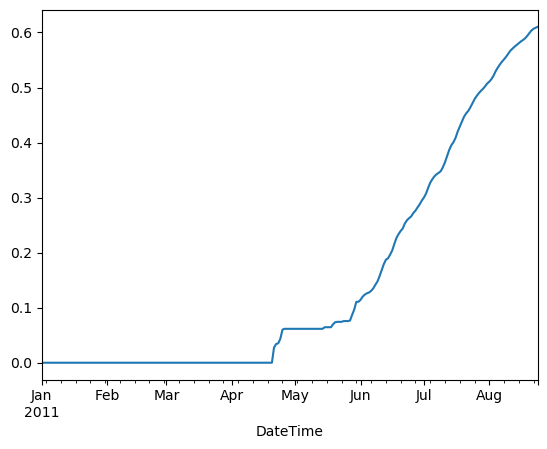

In [36]:
#load meteorological observations
file = 'data/Samoylov_2002-2011_meteorology.tab'
dataset = pd.read_csv(file,delimiter="\t")
dataset['DateTime'] = pd.to_datetime(dataset['Date/Time'])
dataset = dataset.drop(columns=['Date/Time'])

dataset = dataset.set_index(['DateTime'])
dataset = dataset.loc['2011-1-1':'2011-9-1'] 

df_mean = dataset.groupby(by=pd.Grouper(freq='D')).mean() 
meteorology_mean = df_mean   

T_av = meteorology_mean['T2 [°C]'] 

Theta_w = 0.8
Theta_m = 0.1
Theta_o = 0.1

[thaw_depth, G] = ThawDepth(T_av,Theta_w, Theta_m, Theta_o)
thaw_depth.plot()